# *1．要点*

●畳み込みニューラルネットワーク

・画像分類によく用いられる

・下図に示すような情報に次元的なつながりがあれば畳み込みニューラルネットワークで処理ができる




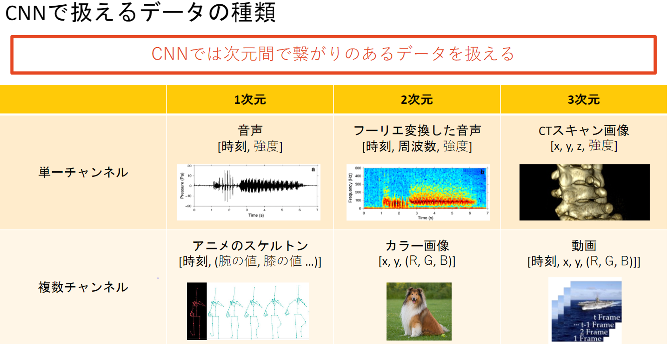

●LeNet

・畳み込みニューラルネットワークの代表的なものの1つ。

『「畳み込み層 – サブサンプリング層」を2回繰り返したのち，全結合層を3層つなげて識別する」という，シンプルな構造を，MNISITの手書き数字文字認識向けに，実用的な画像認識CNNとして提案した

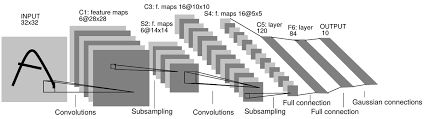

●畳み込み層の全体像

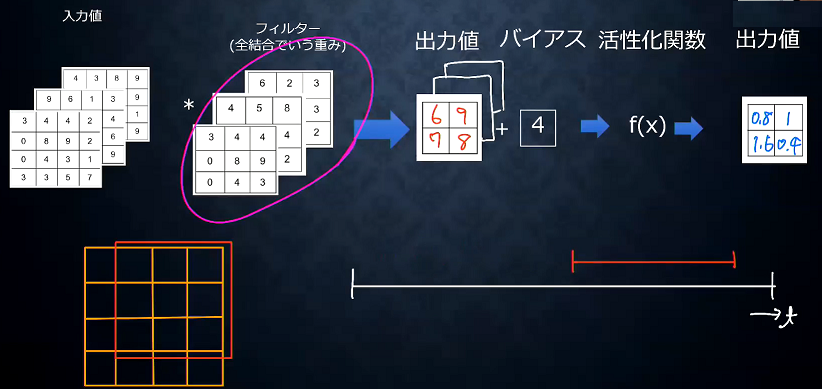

・入力値にフィルターをずらしながら出力値を得る

・次元的なつながりを持つようにフィルターを移動させる

・音声データ（一次元）の場合も同様

・全結合層での学習：全体の構成＝次元の繋がりを保つ（NN:特徴の抽出）＋人間が欲しい結果（fc：全結合層）

●畳み込み層　：畳み込み層では画像の場合、縦、横、チャンネルの3次元のデータをそのまま学習し次に伝えることができる

　　→結論　：3次元の空間情報も学習できるような層が畳み込み層である

●畳み込み層の演算概念

**【バイアス】**

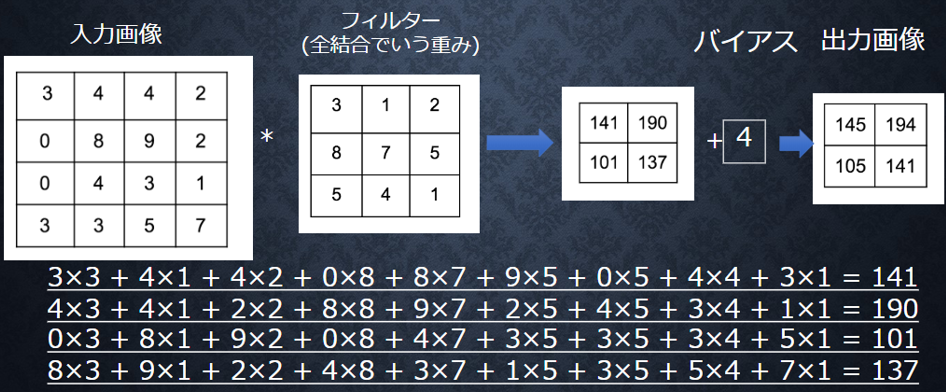

**【パディング】**

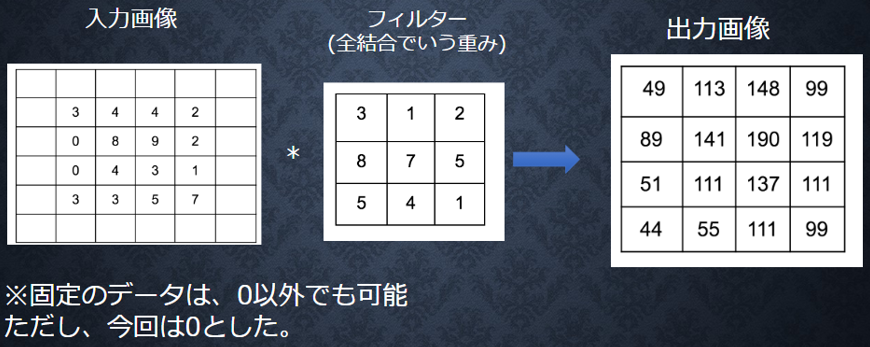

・畳み込みの演算により出力サイズが縮小することは、畳み込み演算を何度も繰り返すディープラーニングでは問題となる

・パディングの役割：出力サイズの調整　空間的なサイズを一定にしたまま次の層へデータを渡すことが可能


**【ストライド】**

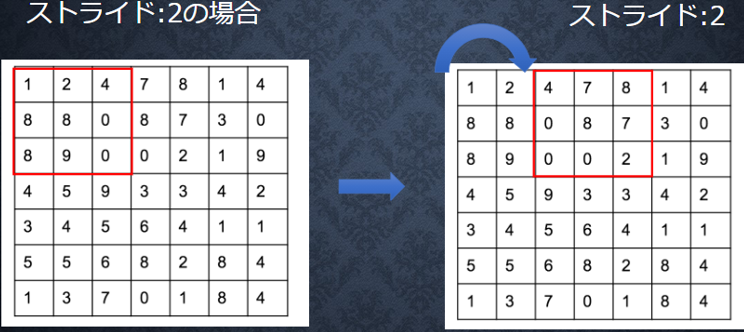

・フィルターを適用する位置の間隔

**【チャンネル】**

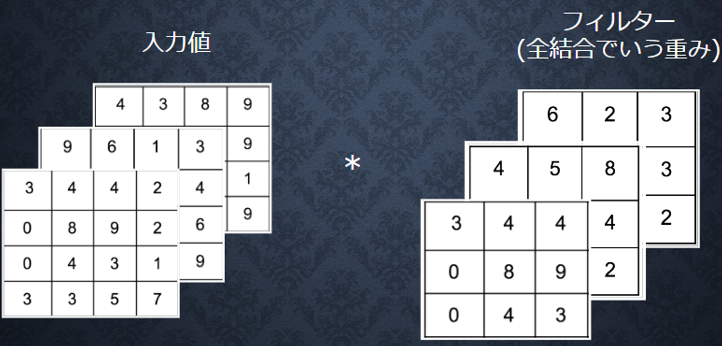

・画像の場合は、縦・横方向に加えてチャンネル方向もあわせて3次元データに対して畳み込み演算を行う必要がある

●全結合層のデメリット：全結合では、縦、横、チャネルの３次元データ（特徴）が１次元のデータとして処理される。RGBの各チャンネル間の関連性が学習に反映されない。

●プーリング層の計算概念

・入力画像の対象領域のMax値（**MaxPooling**）または平均値（**AveragePooling**）を取得



# *2．確認テスト*

**確認テスト**

サイズ6×6の入力画像をサイズ2×2のフィルタで畳み込んだ時の出力画像のサイズを答えよ。スライドとパディングは1とする。

**解答**

$ \displaystyle O_H = \frac{入力画像の高さ + 2 * パディングの高さ - フィルタの高さ}{ストライド}　+　1$ 

$ \displaystyle O_W = \frac{入力画像の幅 + 2 * パディングの幅 - フィルタの幅}{ストライド}　+ 1$

出力画像サイズは　7 × 7

# *3．実装演習*

# *準備*

## Googleドライブのマウント

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## sys.pathの設定

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/E/stage3/DNN_code_colab_lesson_1_2')
sys.path.append('/content/drive/MyDrive/E/stage3/DNN_code_colab_lesson_1_2/lesson_2')

# simple convolution network

## image to column

In [ ]:
import pickle
import numpy as np
from collections import OrderedDict
from common import layers
from common import optimizer
from data.mnist import load_mnist
import matplotlib.pyplot as plt

# 画像データを２次元配列に変換
'''
input_data: 入力値
filter_h: フィルターの高さ
filter_w: フィルターの横幅
stride: ストライド
pad: パディング
'''
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    # N: number, C: channel, H: height, W: width
    N, C, H, W = input_data.shape
    # 切り捨て除算
    out_h = (H + 2 * pad - filter_h)//stride + 1
    out_w = (W + 2 * pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride * out_h
        for x in range(filter_w):
            x_max = x + stride * out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3) # (N, C, filter_h, filter_w, out_h, out_w) -> (N, filter_w, out_h, out_w, C, filter_h)    
    
    col = col.reshape(N * out_h * out_w, -1)
    return col

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
## [try] im2colの処理を確認しよう
・関数内でtransposeの処理をしている行をコメントアウトして下のコードを実行してみよう<br>
・input_dataの各次元のサイズやフィルターサイズ・ストライド・パディングを変えてみよう

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# im2colの処理確認
input_data = np.random.rand(2, 1, 4, 4)*100//1 # number, channel, height, widthを表す
print('========== input_data ===========\n', input_data)
print('==============================')
filter_h = 3
filter_w = 3
stride = 1
pad = 0

========== input_data ===========
 [[[[72. 93. 88. 19.]
   [72. 55.  6. 16.]
   [40. 70. 51. 38.]
   [58.  1. 96. 88.]]]


 [[[36. 87. 42. 43.]
   [41. 72. 48. 27.]
   [38. 55.  3. 82.]
   [82. 83.  2. 17.]]]]


In [ ]:
input_data.shape

(2, 1, 4, 4)

In [ ]:
col = im2col(input_data, filter_h=filter_h, filter_w=filter_w, stride=stride, pad=pad)
print('============= col ==============\n', col)
print('==============================')

============= col ==============
 [[72. 93. 88. 72. 55.  6. 40. 70. 51.]
 [93. 88. 19. 55.  6. 16. 70. 51. 38.]
 [72. 55.  6. 40. 70. 51. 58.  1. 96.]
 [55.  6. 16. 70. 51. 38.  1. 96. 88.]
 [36. 87. 42. 41. 72. 48. 38. 55.  3.]
 [87. 42. 43. 72. 48. 27. 55.  3. 82.]
 [41. 72. 48. 38. 55.  3. 82. 83.  2.]
 [72. 48. 27. 55.  3. 82. 83.  2. 17.]]


## column to image

In [ ]:
# ２次元配列を画像データに変換
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    # N: number, C: channel, H: height, W: width
    N, C, H, W = input_shape
    # 切り捨て除算    
    out_h = (H + 2 * pad - filter_h)//stride + 1
    out_w = (W + 2 * pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2) # (N, filter_h, filter_w, out_h, out_w, C)

    img = np.zeros((N, C, H + 2 * pad + stride - 1, W + 2 * pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride * out_h
        for x in range(filter_w):
            x_max = x + stride * out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
## [try] col2imの処理を確認しよう
・im2colの確認で出力したcolをimageに変換して確認しよう

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# ここにcol2imでの処理を書こう
img = col2im(col, input_shape=input_data.shape, filter_h=filter_h, filter_w=filter_w, stride=stride, pad=pad)
print(img)

[[[[ 72. 186. 176.  19.]
   [144. 220.  24.  32.]
   [ 80. 280. 204.  76.]
   [ 58.   2. 192.  88.]]]


 [[[ 36. 174.  84.  43.]
   [ 82. 288. 192.  54.]
   [ 76. 220.  12. 164.]
   [ 82. 166.   4.  17.]]]]


## convolution class

In [ ]:
class Convolution:
    # W: フィルター, b: バイアス
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        # 中間データ（backward時に使用）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # フィルター・バイアスパラメータの勾配
        self.dW = None
        self.db = None

    def forward(self, x):
        # FN: filter_number, C: channel, FH: filter_height, FW: filter_width
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        # 出力値のheight, width
        out_h = 1 + int((H + 2 * self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2 * self.pad - FW) / self.stride)
        
        # xを行列に変換
        col = im2col(x, FH, FW, self.stride, self.pad)
        # フィルターをxに合わせた行列に変換
        col_W = self.W.reshape(FN, -1).T

        out = np.dot(col, col_W) + self.b
        # 計算のために変えた形式を戻す
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0, 2, 3, 1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        # dcolを画像データに変換
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx


## pooling class

In [ ]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        
        # xを行列に変換
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        # プーリングのサイズに合わせてリサイズ
        col = col.reshape(-1, self.pool_h*self.pool_w)
        
        #maxプーリング
        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx


## sinple convolution network class

In [ ]:
class SimpleConvNet:
    # conv - relu - pool - affine - relu - affine - softmax
    def __init__(self, input_dim=(1, 28, 28), conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']        
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2 * filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size / 2) * (conv_output_size / 2))

        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Conv1'] = layers.Convolution(self.params['W1'], self.params['b1'], conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = layers.Relu()
        self.layers['Pool1'] = layers.Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = layers.Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = layers.Relu()
        self.layers['Affine2'] = layers.Affine(self.params['W3'], self.params['b3'])

        self.last_layer = layers.SoftmaxWithLoss()

    def predict(self, x):
        for key in self.layers.keys():
            x = self.layers[key].forward(x)
        return x
        
    def loss(self, x, d):
        y = self.predict(x)
        return self.last_layer.forward(y, d)

    def accuracy(self, x, d, batch_size=100):
        if d.ndim != 1 : d = np.argmax(d, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            td = d[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == td) 
        
        return acc / x.shape[0]

    def gradient(self, x, d):
        # forward
        self.loss(x, d)
        
        # backward
        dout = 1
        dout = self.last_layer.backward(dout)
        layers = list(self.layers.values())
        
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grad = {}
        grad['W1'], grad['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grad['W2'], grad['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grad['W3'], grad['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grad

In [ ]:
from common import optimizer

# データの読み込み
(x_train, d_train), (x_test, d_test) = load_mnist(flatten=False)

print("データ読み込み完了")

# 処理に時間のかかる場合はデータを削減 
x_train, d_train = x_train[:5000], d_train[:5000]
x_test, d_test = x_test[:1000], d_test[:1000]


network = SimpleConvNet(input_dim=(1,28,28), conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)

optimizer = optimizer.Adam()

iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10


データ読み込み完了


In [ ]:
for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]
    
    grad = network.gradient(x_batch, d_batch)
    optimizer.update(network.params, grad)

    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)

    if (i+1) % plot_interval == 0:
        accr_train = network.accuracy(x_train, d_train)
        accr_test = network.accuracy(x_test, d_test)
        accuracies_train.append(accr_train)
        accuracies_test.append(accr_test)
        
        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))               


Generation: 10. 正答率(トレーニング) = 0.3574
                : 10. 正答率(テスト) = 0.345
Generation: 20. 正答率(トレーニング) = 0.5678
                : 20. 正答率(テスト) = 0.536
Generation: 30. 正答率(トレーニング) = 0.7544
                : 30. 正答率(テスト) = 0.724
Generation: 40. 正答率(トレーニング) = 0.778
                : 40. 正答率(テスト) = 0.756
Generation: 50. 正答率(トレーニング) = 0.8294
                : 50. 正答率(テスト) = 0.799
Generation: 60. 正答率(トレーニング) = 0.8414
                : 60. 正答率(テスト) = 0.807
Generation: 70. 正答率(トレーニング) = 0.8748
                : 70. 正答率(テスト) = 0.837
Generation: 80. 正答率(トレーニング) = 0.8848
                : 80. 正答率(テスト) = 0.855
Generation: 90. 正答率(トレーニング) = 0.8932
                : 90. 正答率(テスト) = 0.867
Generation: 100. 正答率(トレーニング) = 0.8894
                : 100. 正答率(テスト) = 0.845
Generation: 110. 正答率(トレーニング) = 0.8954
                : 110. 正答率(テスト) = 0.861
Generation: 120. 正答率(トレーニング) = 0.902
                : 120. 正答率(テスト) = 0.877
Generation: 130. 正答率(トレーニング) = 0.911
                : 130. 正答率(テスト) = 0.889
Generat